***Building a Recommendation Engine for Restaurants based on Yelp Reviews***

# *PySpark Setup*

In [ ]:
#Mounting drive on Colab to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Installing Java 
!apt-get install openjdk-8-jdk-headless -qq 

Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u275-b01-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u275-b01-0ubuntu1~18.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u275-b01-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u275-b01-0ubuntu1~18.04) ...
Setting up openjdk-8-jre-headless:amd64 (8u275-b01-0ubuntu1~18.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/orbd to provide /usr/bin/orbd (orbd) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/servertool to provide /usr/bin/servertool (servertool) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/tnameserv to provide /usr/bin/tnameserv (tnameserv) in auto mode
Setting up ope

In [ ]:
#Installing Spark
!wget https://mirrors.estointernet.in/apache/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz

--2020-12-03 14:19:03--  https://mirrors.estointernet.in/apache/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
Resolving mirrors.estointernet.in (mirrors.estointernet.in)... 43.255.166.254, 2403:8940:3:1::f
Connecting to mirrors.estointernet.in (mirrors.estointernet.in)|43.255.166.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233333392 (223M) [application/octet-stream]
Saving to: ‘spark-2.4.7-bin-hadoop2.7.tgz’

spark-2.4.7-bin-had 100%[===================>] 222.52M  7.99MB/s    in 38s     

2020-12-03 14:19:42 (5.86 MB/s) - ‘spark-2.4.7-bin-hadoop2.7.tgz’ saved [233333392/233333392]



In [ ]:
#Extracting the tar file
!tar xf spark-2.4.7-bin-hadoop2.7.tgz

In [ ]:
#Setting environment variables path
import os
#os.environ() works as a mapping object that represents user's environmental variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" #Mapping JAVA environment
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7" #Mapping Spark environment

In [ ]:
!pip install -q findspark

In [ ]:
#Initializing Pyspark
import findspark
findspark.init() #Helps us by making pyspark as importable library

In [ ]:
#Importing libraries
import pyspark
from pyspark import SparkContext, SparkConf 
#SparkContext - Main entry point for Spark functionality 
#SparkConf - For configuring spark
from pyspark.sql import SparkSession 
#SparkSession - Main entry point for SQL functionality. It can be used to create dataframes.
#SparkSession was introduced in version 2.0. 
#It is an entry point to underlying Spark functionality in order to programmatically create Spark RDD, DataFrame and DataSet.

In [ ]:
spark = SparkSession.builder.config("spark.sql.codegen",value=False).getOrCreate()
#spark.sql.codegen - It asks SparkSQL to compile each query to Java byte code before executing it. 
#The codegen option helps run long and repeated queries substantially faster.
#The getOrCreate() function gets an existing Spark session or creates a new one

In [ ]:
#Importing libararies for SQL functions
from pyspark.sql.functions import *
from pyspark.sql import functions as F

# *Extracting Data from Drive and Basic Preparation*

**Reviews Dataset**

In [ ]:
#Reading the json file
sample_reviews = spark.read.json('/content/drive/Shareddrives/Yelp - JSON/part-00000-237dfcd0-e706-483a-acfc-5f73ab35f25d-c000.json')

Actions and transformations are 2 operations. Transformations create a new dataset from an existing one and actions return a value to the driver program after running a computation on the dataset. 

Example:

Map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program

You should consider caching/persisting when:
* you want to use an RDD many times
* you want to perform multiple actions on the same RDD
* you want to create a long chain of (or very expensive) transformations

Spark automatically monitors cache usage on each node and drops out old data partitions in a least-recently-used (LRU) fashion. If you would like to manually remove an RDD instead of waiting for it to fall out of the cache, use the RDD.unpersist() method.

In [ ]:
sample_reviews.persist()

DataFrame[business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, user_id: string]

In [ ]:
sample_reviews.show() #show(n) - prints first n rows

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|-MhfebM0QIsKt87iD...|   0|2015-04-15 05:21:16|    0|xQY8N_XvtGbearJ5X...|  2.0|As someone who ha...|     5|OwjRMXRC0KyPrIlcj...|
|lbrU8StCq3yDfr-QM...|   0|2013-12-07 03:16:52|    1|UmFMZ8PyXZTY2Qcwz...|  1.0|I am actually hor...|     1|nIJD_7ZXHq-FX8byP...|
|HQl28KMwrEKHqhFrr...|   0|2015-12-05 03:18:11|    0|LG2ZaYiOgpr2DK_90...|  5.0|I love Deagan's. ...|     1|V34qejxNsCbcgD8C0...|
|5JxlZaqCnk1MnbgRi...|   0|2011-05-27 05:30:52|    0|i6g_oA9Yf9Y31qt0w...|  1.0|Dismal, lukewarm,...|     0|ofKDkJKXSKZXu5xJN...|
|IS4cv902ykd8wj1TR...|   0|2017-01-14 21:56:57|    0|6TdNDKywdbjoTkize...|  4.0|Oh happy d

In [ ]:
sample_reviews.count() #count() - returns the number of rows in the dataframe

10000

In [ ]:
#Creating a function to check for null values
def check_for_null_values(df):
  '''This function is used to check the null values in each column'''
  '''Parameter : dataframe'''
  for i in df.columns:
    print('---'+i+'---')
    print(df.where(col(i).isNull()).show())  #isNull() - Returns true if the value is null

In [ ]:
#Checking for null values
check_for_null_values(sample_reviews.select(['business_id','text']))

---business_id---
+-----------+----+
|business_id|text|
+-----------+----+
+-----------+----+

None
---text---
+-----------+----+
|business_id|text|
+-----------+----+
+-----------+----+

None


In [ ]:
#Removing all null values
sample_reviews = sample_reviews.na.drop()

In [ ]:
#Count after removing values
sample_reviews.count()

10000

In [ ]:
#Grouping all the reviews together on the basis of business id 
reviews = sample_reviews.select('business_id','text').groupby('business_id').agg(F.collect_list("text")).sort('business_id')

In [ ]:
reviews.persist()

DataFrame[business_id: string, collect_list(text): array<string>]

In [ ]:
reviews.show() #shows all the reviews for a each business grouped together

+--------------------+--------------------+
|         business_id|  collect_list(text)|
+--------------------+--------------------+
|-0LPtgJC31FWMrMv3...|[After some chang...|
|-2ToCaDFpTNmmg3QF...|[horrible.   Neve...|
|-2X9U7v-Avoib-ki0...|[Would Highly Rec...|
|-4_n--u4Z_SBbgz1z...|[Five stars all t...|
|-5L8zOxibac-vBrsY...|[I had the pleasu...|
|-7-uHFjQLH_uxPauY...|[Great Italian fo...|
|-74zTQjLpOTzgvPTs...|[I'm very upset w...|
|-8F04F54iDT6VgWPC...|[Super cute place...|
|-9Ff8WEoiFsw_mfmJ...|[The smoked meat ...|
|-A6iU1EJdtDr-APcJ...|[First visit here...|
|-BbnAc9YEO6pjvJGE...|[Um it's pretty a...|
|-BmqghX1sv7sgsxOI...|[Was a little ske...|
|-CbDQXiuKzPQ0_jiU...|[OMG, this place ...|
|-D2vGSq_SvuCmHdqs...|[I recently answe...|
|-DHKF52ALa4B2ls1V...|[I was sent to Vi...|
|-DcE_4T0_iRKGLARm...|[It's tough to me...|
|-EohS3nXZGl6odE9L...|[This place sucks...|
|-FNquqGseSCVMWo7K...|[The food isn't g...|
|-FtngCwHCD2tRlH8j...|[For father's day...|
|-H3hHmLfDmXQyuAlb...|[This plac

In [ ]:
reviews.count()

4398

Spark automatically persists some intermediate data in shuffle operations (e.g. reduceByKey), even without users calling persist.

Spark automatically monitors every persist() and cache() calls you make and it checks usage on each node and drops persisted data if not used or by using least-recently-used (LRU) algorithm. You can also manually remove using unpersist() method. unpersist() marks the Dataset as non-persistent, and remove all blocks for it from memory and disk.

In [ ]:
# sample_reviews.unpersist() 
#unpersist() - makes the dataframe non persistent and removes all the memory and disk

*Since RDD and all of its dependencies are recomputed each time an action is called on the RDD, we unpersist() dataframes for computation ease.*

**Business Dataset**

In [ ]:
#Reading the json file
business = spark.read.json('/content/drive/Shareddrives/Yelp - JSON/yelp_academic_dataset_business.json')

In [ ]:
business.persist()

DataFrame[address: string, attributes: struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, business_id: string, categories: string, city: string, hours: struct<Friday:string,Monday:string,Saturday:string

In [ ]:
business.show()

+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|           city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|     10913 Bailey Rd|[,,,,,,, True,, T...|f9NumwFMBDn751xgF...|Active Life, Gun/...|      Cornelius|[11:0-20:0, 10:0-...|      1|   35.4627242|    -80.8526119|The Range At Lake...|      28031|          36|  3.5|   NC|
|8880 E Via Linda,...|[,,,,,,,,,,, True...|Yzvjg0SayhoZgCljU...|Health & Medical,...|     Scottsdale|                null|  

In [ ]:
business.count()

209393

*Note:*
* The 'business' dataframe contains information about different businesses like restaurants, pet shops, hardware stores etc. 

* Since we are interested only in restaurants, we are extracting the data pertaining to restaurants here. We do this by filtering the businesses that contain 'Restaurant' in their 'categories' column.

In [ ]:
#Filtering the business dataset for Restaurants
rests = business.filter(business['categories'].contains('Restaurant')).select('business_id','categories','name','stars').sort('business_id')

In [ ]:
rests.persist()

DataFrame[business_id: string, categories: string, name: string, stars: double]

In [ ]:
rests.count()

63961

*Note:* Here, we are checking the uniqueness of the business_id and ensuring that no restaurant is given the same id i.e. no two restaurants should have the same business id.

In [ ]:
#Checking for Duplicate values
rests.dropDuplicates(['business_id']).count() 

63961

In [ ]:
rests.show()

+--------------------+--------------------+--------------------+-----+
|         business_id|          categories|                name|stars|
+--------------------+--------------------+--------------------+-----+
|--1UhMGODdWsrMast...|Restaurants, Mexican|    The Spicy Amigos|  4.0|
|--6MefnULPED_I942...|Chinese, Restaurants|John's Chinese BB...|  3.0|
|--9e1ONYQuAa-CB_R...|Seafood, Cajun/Cr...|Delmonico Steakhouse|  4.0|
|--DaPTJW3-tB1vP-P...|Restaurants, Brea...|     Sunnyside Grill|  4.0|
|--FBCX-N37CMYDfs7...|American (New), N...|The Bar At Bermud...|  4.0|
|--FnvijzY20d1nk9H...|Restaurants, Mexican|Mr. Pancho Mexica...|  4.5|
|--GM_ORV2cYS-h38D...|Restaurants, Sala...|         Mm Mm Pizza|  4.0|
|--I7YYLada0tSLkOR...|Bars, Nightlife, ...|Happy Moose Bar a...|  3.5|
|--KCl2FvVQpvjzmZS...|Sandwiches, Resta...|Hungry Howie's Pizza|  3.0|
|--Ni3oJ4VOqfOEu7S...|Restaurants, Chic...|                 KFC|  1.5|
|--S62v0QgkqQaVUhF...|American (Traditi...|             Denny's|  2.0|
|--Srz

In [ ]:
#Checking for null values
check_for_null_values(rests)

---business_id---
+-----------+----------+----+-----+
|business_id|categories|name|stars|
+-----------+----------+----+-----+
+-----------+----------+----+-----+

None
---categories---
+-----------+----------+----+-----+
|business_id|categories|name|stars|
+-----------+----------+----+-----+
+-----------+----------+----+-----+

None
---name---
+-----------+----------+----+-----+
|business_id|categories|name|stars|
+-----------+----------+----+-----+
+-----------+----------+----+-----+

None
---stars---
+-----------+----------+----+-----+
|business_id|categories|name|stars|
+-----------+----------+----+-----+
+-----------+----------+----+-----+

None


Since the sample reviews generated contains reviews from all different businesses, we apply a inner join on 'reviews' and 'rests' to extract reviews of only Restaurants.

*Remember, we are considering only a subset of reviews, there is a possibility that we don't have reviews for a bunch of restaurant. Applying an inner join ensures that we retain only those 'Restaurants' which have reviews.*

In [ ]:
#Applying Inner Join
rests_reviews = reviews.join(rests,on=['business_id'],how='inner') 

In [ ]:
rests_reviews.show() 

+--------------------+--------------------+--------------------+--------------------+-----+
|         business_id|  collect_list(text)|          categories|                name|stars|
+--------------------+--------------------+--------------------+--------------------+-----+
|-5L8zOxibac-vBrsY...|[I had the pleasu...|Nightlife, Americ...|         Ed's Tavern|  3.5|
|-7-uHFjQLH_uxPauY...|[Great Italian fo...|Wine Bars, Bars, ...|Prego Cucina Ital...|  3.5|
|-8F04F54iDT6VgWPC...|[Super cute place...|Coffee & Tea, Res...|    Ineffable Ca Phe|  4.5|
|-BbnAc9YEO6pjvJGE...|[Um it's pretty a...|Noodles, Ramen, J...|            Sansotei|  4.0|
|-BmqghX1sv7sgsxOI...|[Was a little ske...|Restaurants, Ethi...|Merkato Ethiopian...|  4.0|
|-CbDQXiuKzPQ0_jiU...|[OMG, this place ...|Restaurants, Thai...|Taiga Modern Japa...|  4.0|
|-D2vGSq_SvuCmHdqs...|[I recently answe...|Restaurants, Italian|   Sugo Caffe Italia|  3.5|
|-DcE_4T0_iRKGLARm...|[It's tough to me...|Nightlife, Mexica...|El Ranchero Of T

# *Preprocessing the data*

In [ ]:
#Importing libraries 
import fileinput,re
import os
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Removing stopwords
def remove_stopwords(text):
  filtered_words = [w for w in text.split()  if ((not w in sw) and (len(w)>1))]
  return " ".join(filtered_words)

Why are we using Stemming instead of Lemmatisation?

=>  Stemming takes a best guess of where to snip a word based on how it looks, while lemmatization is a more calculated process. Lemmatisation is computationally expensive and much more intensive than Stemming. Hence we thought it would be appropriate to use Stemming instead of Lemmatisation given our limited resources.

In [ ]:
#Stemming
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer('english')
Stem1 = lambda x:snowball.stem(x)
def stem2(x):
  return ' '.join(list(map(Stem1,x.split())))

In [ ]:
#Creating a function for preprocessing and cleaning the data
import string
def preprocess(x):
  x = x.lower()
  x = x.strip()
  x = x.replace("\n", " ")
  x = re.sub("[^a-z]", " ",x)
  x = remove_stopwords(x)
  x = ' '.join(list(map(Stem1,x.split())))
  return x

*Note:*

map() transformation takes in a function and applies it to each element in the RDD and the result of the function is a new value of each element in the resulting RDD.
mapValues is only applicable for PairRDDs, meaning RDDs of the form RDD[(A, B)]. 
In that case, mapValues operates on the value only (the second part of the tuple),while map operates on the entire record (tuple of key and value).

Here, we are first mapping the review, category, restaurant name and star to business id and then preprocessing using the mapvalues() function.

Final Output: (business_id, (review, category, name, stars))

In [ ]:
#Appling map to preprocess the data
data = rests_reviews.rdd.map(lambda x: (x[0],(' '.join(x[1]),x[2],x[3],x[4]))).mapValues(lambda x: (preprocess(x[0]),x[1],x[2].lower(),x[3]))

In [ ]:
data.persist()

PythonRDD[171] at RDD at PythonRDD.scala:53

In [ ]:
data.take(5) 

[('-5L8zOxibac-vBrsYtxXbQ',
  ('pleasur host cd releas parti ed week definit made right choic select ed number charlott venu consid start finish good experi mani folk attend concert comment good servic staff help friend effici ed lot space insid mani tvs expans deck back great place relax outsid ed comfort fun place definit recommend visit soon okay star bar atmospher star food food good bar food great bar food rate first need understand bar tuck neat edg dilworth walkabl mani surround home thus make easi choic anyon need late night grub comraderi read peopl mingl open late plus pool tabl also plus like pick music touch tune devic decent beer select tap beer snob go somewher els like beer serv bucket mayb star ed fun locat great expect new patio popular warmer month',
   'Nightlife, American (Traditional), Burgers, Bars, Restaurants, Sports Bars',
   "ed's tavern",
   3.5)),
 ('-7-uHFjQLH_uxPauYtd8iA',
  ('great italian food tuck away top eau clair mall noth bad could say restaur excep

toDF - Returns a new dataframe with new specified column names

In [ ]:
#Applying map and converting it to a Dataframe
main_df = data.map(lambda x: (x[0],x[1][0],x[1][1],x[1][2],x[1][3])).toDF(['business_id','review','categories','name','ratings'])

In [ ]:
main_df.persist()

DataFrame[business_id: string, review: string, categories: string, name: string, ratings: double]

In [ ]:
main_df.show()

+--------------------+--------------------+--------------------+--------------------+-------+
|         business_id|              review|          categories|                name|ratings|
+--------------------+--------------------+--------------------+--------------------+-------+
|-5L8zOxibac-vBrsY...|pleasur host cd r...|Nightlife, Americ...|         ed's tavern|    3.5|
|-7-uHFjQLH_uxPauY...|great italian foo...|Wine Bars, Bars, ...|prego cucina ital...|    3.5|
|-8F04F54iDT6VgWPC...|super cute place ...|Coffee & Tea, Res...|    ineffable ca phe|    4.5|
|-BbnAc9YEO6pjvJGE...|um pretti averag ...|Noodles, Ramen, J...|            sansotei|    4.0|
|-BmqghX1sv7sgsxOI...|littl skeptic fir...|Restaurants, Ethi...|merkato ethiopian...|    4.0|
|-CbDQXiuKzPQ0_jiU...|omg place fabul g...|Restaurants, Thai...|taiga modern japa...|    4.0|
|-D2vGSq_SvuCmHdqs...|recent answer job...|Restaurants, Italian|   sugo caffe italia|    3.5|
|-DcE_4T0_iRKGLARm...|tough measur mexi...|Nightlife, Mexica

In [ ]:
#Checking for presence of empty reviews
main_df.filter(main_df['review']=='').show()

+--------------------+------+--------------------+---------------------+-------+
|         business_id|review|          categories|                 name|ratings|
+--------------------+------+--------------------+---------------------+-------+
|x-H-2BYL2XoDDLiub...|      |Szechuan, Chinese...|xiang wei xuan-湘味轩|    4.5|
+--------------------+------+--------------------+---------------------+-------+



In [ ]:
main_df.count()

2281

In [ ]:
#Filtering the dataset for non empty reviews
main_df = main_df.filter(main_df['review']!='')

In [ ]:
main_df.count()

2280

# *Calculating similarity between two restaurants based on their reviews*

### *Calculating TF-IDF values*

In [ ]:
#Importing Libraries
import math
from pyspark.sql.functions import *

*Note:*

reduceByKey() - reduces the value for each key

flatMap() - applies the function to all the elements in the RDD and flattens the results

FORMULA FOR TERM FREQUENCY:
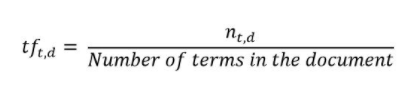

In [ ]:
#For calculating term frequency
tf_1 = main_df.rdd.map(lambda x:(x[0],x[1])).flatMap(lambda x: [((x[0],i),1) for i in x[1].split()]).reduceByKey(lambda x,y:x+y)  #((business_id,word),count)
tf_2 = tf_1.map(lambda x: (x[0][0],(x[0][1],x[1])))  #(business_id,(word,count))
tf_3 = main_df.rdd.map(lambda x: (x[0],len(x[1].split()))) #(business_id,number of terms in the document)
tf_4 = tf_2.join(tf_3)  #(business_id,((word,number of time that words has appeared in the document),len of the document))
final_tf = tf_4.map(lambda x:(x[1][0][0],(x[0],x[1][0][1]/x[1][1]))) #(word,(business_id,tf)) 

In [ ]:
final_tf.persist()

PythonRDD[226] at RDD at PythonRDD.scala:53

In [ ]:
#For reference we print tf_1, tf_2, tf_3, tf_4 and final_tf
tf_1.take(5) #((business_id,word),count)

[(('-5L8zOxibac-vBrsYtxXbQ', 'charlott'), 1),
 (('-CbDQXiuKzPQ0_jiUz03aw', 'basil'), 1),
 (('-CbDQXiuKzPQ0_jiUz03aw', 'date'), 1),
 (('-D2vGSq_SvuCmHdqsDxzeA', 'averag'), 1),
 (('-FtngCwHCD2tRlH8jpj_Ag', 'chosen'), 1)]

In [ ]:
tf_2.take(5) #(business_id,(word,count))

[('-5L8zOxibac-vBrsYtxXbQ', ('charlott', 1)),
 ('-CbDQXiuKzPQ0_jiUz03aw', ('basil', 1)),
 ('-CbDQXiuKzPQ0_jiUz03aw', ('date', 1)),
 ('-D2vGSq_SvuCmHdqsDxzeA', ('averag', 1)),
 ('-FtngCwHCD2tRlH8jpj_Ag', ('chosen', 1))]

In [ ]:
tf_3.take(5) #(business_id,number of terms in the document)

[('-5L8zOxibac-vBrsYtxXbQ', 130),
 ('-7-uHFjQLH_uxPauYtd8iA', 47),
 ('-8F04F54iDT6VgWPCgybug', 66),
 ('-BbnAc9YEO6pjvJGEtFbVQ', 132),
 ('-BmqghX1sv7sgsxOIS2yAg', 76)]

In [ ]:
tf_4.take(5) #(business_id,((word,number of time that words has appeared in the document),len of the document))

[('JZEw18_OhSzFj0IfXF6v6Q', (('eighth', 1), 78)),
 ('JZEw18_OhSzFj0IfXF6v6Q', (('pie', 6), 78)),
 ('JZEw18_OhSzFj0IfXF6v6Q', (('someth', 1), 78)),
 ('JZEw18_OhSzFj0IfXF6v6Q', (('hope', 1), 78)),
 ('JZEw18_OhSzFj0IfXF6v6Q', (('portion', 1), 78))]

In [ ]:
final_tf.take(5) #(word,(business_id,tf)) 

[('eighth', ('JZEw18_OhSzFj0IfXF6v6Q', 0.01282051282051282)),
 ('pie', ('JZEw18_OhSzFj0IfXF6v6Q', 0.07692307692307693)),
 ('someth', ('JZEw18_OhSzFj0IfXF6v6Q', 0.01282051282051282)),
 ('hope', ('JZEw18_OhSzFj0IfXF6v6Q', 0.01282051282051282)),
 ('portion', ('JZEw18_OhSzFj0IfXF6v6Q', 0.01282051282051282))]

In [ ]:
data_count = main_df.count()

In [ ]:
data_count

2280

FORMULA FOR INVERSE DOCUMENT FREQUENCY:
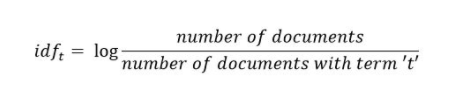

In [ ]:
idf_1 = final_tf.map(lambda x: (x[0],(x[1][0],x[1][1],1))).map(lambda x:(x[0],x[1][2])).reduceByKey(lambda x,y:x+y)  #(word,(business_id,tf,1)) #(word,1) #(word,number of documents in which the word has appeared)
final_idf = idf_1.map(lambda x: (x[0],math.log10(data_count/x[1]))) #calculating idf

In [ ]:
#For reference, we print idf_1, final_idf
idf_1.take(5) #(word,number of documents in which the word has appeared)

[('ladi', 102), ('mayb', 237), ('greaterthan', 1), ('caus', 61), ('step', 51)]

In [ ]:
final_idf.take(5) #(word,idf)

[('ladi', 1.3493346752385362),
 ('mayb', 0.9831865009903499),
 ('greaterthan', 3.357934847000454),
 ('caus', 1.5726050119896868),
 ('step', 1.6503646709025173)]

In [ ]:
#Merging tf and idf values
tf_idf = final_tf.join(final_idf) 

In [ ]:
tf_idf.take(5) #(word,((business_id,tf value),idf_value)))

[('ladi',
  (('yNS9sDkxDGP9DQV7ilS0NQ', 0.021739130434782608), 1.3493346752385362)),
 ('ladi',
  (('x5iQFVJkFl7fSXC6uVjwPw', 0.011428571428571429), 1.3493346752385362)),
 ('ladi',
  (('Ns20WGWn6s6niKAGIQB4UQ', 0.002053388090349076), 1.3493346752385362)),
 ('ladi',
  (('yBxzqKXHhvNVaFnEOd4f7Q', 0.08333333333333333), 1.3493346752385362)),
 ('ladi',
  (('3IY-JtcZHBOSzFD53SSXLA', 0.01098901098901099), 1.3493346752385362))]

FORMULA FOR TF-IDF: 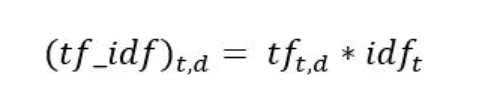

In [ ]:
#Calculating tf-idf
final_tfidf = tf_idf.map(lambda x: (x[1][0][0],(x[0],x[1][0][1],x[1][1],x[1][0][1]*x[1][1]))).sortByKey() #(business_id,(word,tf,idf,tf*idf))

In [ ]:
final_tfidf.persist()

PythonRDD[260] at RDD at PythonRDD.scala:53

In [ ]:
final_tfidf.take(5) #(business_id,(word,tf,idf,tf*idf))

[('-5L8zOxibac-vBrsYtxXbQ',
  ('insid', 0.007692307692307693, 1.0057523288890913, 0.007736556376069933)),
 ('-5L8zOxibac-vBrsYtxXbQ',
  ('week', 0.007692307692307693, 1.0336523917027611, 0.007951172243867394)),
 ('-5L8zOxibac-vBrsYtxXbQ',
  ('food', 0.03076923076923077, 0.16508873181161213, 0.005079653286511143)),
 ('-5L8zOxibac-vBrsYtxXbQ',
  ('made', 0.007692307692307693, 0.6369491028467147, 0.004899608483436267)),
 ('-5L8zOxibac-vBrsYtxXbQ',
  ('night', 0.007692307692307693, 0.7254775548157295, 0.005580596575505612))]

*Bag of words:* All the unique words in all our reviews

In [ ]:
#Extracting all the words present in the review to form bag of words
bow = final_tfidf.map(lambda x : (x[1][0])).distinct().collect()

In [ ]:
#Printing some of the distinct words present
bow[0:5]

['step', 'ladi', 'caus', 'chiliquia', 'gobbl']

In [ ]:
len(bow)

13260

In [ ]:
#Creating a function to extract the index position of each word
def find_word(l,word):
  if word in l:
    return l.index(word)
  else:
    return 0

In [ ]:
find_word(bow,'best')

495

collect_list() - returns a list of objects

Recall, schema of final_tfidf - (business_id, (word, tf, idf, tf*idf))

In [ ]:
#Finding index value of each word and storing the final_tfidf into a Dataframe by grouping on the basis of business id
df = final_tfidf.map(lambda x: (x[0],x[1][0],x[1][3],find_word(bow,x[1][0]))).toDF(["business_id","Token","TF-IDF","index"]).groupby('business_id').agg(F.collect_list("Token"),F.collect_list("TF-IDF"),F.collect_list("index"))

In [ ]:
df.persist()

DataFrame[business_id: string, collect_list(Token): array<string>, collect_list(TF-IDF): array<double>, collect_list(index): array<bigint>]

In [ ]:
df.show()

+--------------------+--------------------+--------------------+--------------------+
|         business_id| collect_list(Token)|collect_list(TF-IDF)| collect_list(index)|
+--------------------+--------------------+--------------------+--------------------+
|4lCTd6-EzOuKl4YbH...|[insid, night, ta...|[0.02578852125356...|[204, 664, 789, 1...|
|4x8W4quFhhuTZlsoU...|[servic, thru, ei...|[0.05575072019056...|[1491, 2156, 2482...|
|ATeOjZzE3VOI-RW7F...|[equal, burger, b...|[0.00692976558221...|[115, 224, 256, 2...|
|RMjCnixEY5i12Ciqn...|[write, food, far...|[0.00593782862583...|[223, 437, 552, 5...|
|VHsNB3pdGVcRgs6C3...|[step, unimpress,...|[0.01279352458063...|[0, 388, 437, 495...|
|_Wyo52ijeq3QgcmkI...|[food, noodl, cri...|[0.00971110187127...|[437, 511, 921, 3...|
|ipFreSFhjClfNETuM...|[food, sport, ser...|[0.00868888062166...|[437, 1237, 1491,...|
|vbUABNAQI2iwN7v0x...|[room, insid, din...|[0.01905151664921...|[41, 204, 340, 47...|
|x1fx7C_tc064cFATj...|[food, best, leag...|[0.00825443

In [ ]:
df.count()

2280

In [ ]:
#Sorting the dataframes on the basis of business_id
df = df.sort('business_id')
main_df = main_df.sort('business_id')

In [ ]:
#Joining the dataframes on the basis of business_id
intermediate_df_1 = df.join(main_df,on='business_id',how='inner')

In [ ]:
intermediate_df_1.persist()

DataFrame[business_id: string, collect_list(Token): array<string>, collect_list(TF-IDF): array<double>, collect_list(index): array<bigint>, review: string, categories: string, name: string, ratings: double]

In [ ]:
intermediate_df_1.count()

2280

In [ ]:
intermediate_df_1.show(10,False)

+----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

zipWithIndex() : 

Zips the RDD with its element indices.
The ordering is first based on the partition index and then the ordering of items within each partition. So the first item in the first partition gets index 0, and the last item in the last partition receives the largest index.

In [ ]:
index_df = intermediate_df_1.rdd.map(lambda x:x[0]).zipWithIndex().toDF(['business_id','index_id'])

In [ ]:
index_df.show(20,False)

+----------------------+--------+
|business_id           |index_id|
+----------------------+--------+
|-5L8zOxibac-vBrsYtxXbQ|0       |
|-7-uHFjQLH_uxPauYtd8iA|1       |
|-8F04F54iDT6VgWPCgybug|2       |
|-BbnAc9YEO6pjvJGEtFbVQ|3       |
|-BmqghX1sv7sgsxOIS2yAg|4       |
|-CbDQXiuKzPQ0_jiUz03aw|5       |
|-D2vGSq_SvuCmHdqsDxzeA|6       |
|-DcE_4T0_iRKGLARmjsjUw|7       |
|-EohS3nXZGl6odE9Lx5BSw|8       |
|-FNquqGseSCVMWo7KbK-Tg|9       |
|-FtngCwHCD2tRlH8jpj_Ag|10      |
|-H3hHmLfDmXQyuAlb3qFfg|11      |
|-JKp9ykFyhswkIQ6XhhJOQ|12      |
|-Jhlh8Scjy669NdtCfKSSg|13      |
|-MC7EFxTsyKMKB3zeP_FIQ|14      |
|-PGsEXB6DFTVKa1eDOlzWA|15      |
|-QC71Wuh0TyJI0RAZ3d0Iw|16      |
|-RIWE3MU3GCHM5KIW7PLww|17      |
|-TVXOYL6kvKP1uW6ND9PIg|18      |
|-U0liwRSHGYBEMYVj8kFmQ|19      |
+----------------------+--------+
only showing top 20 rows



In [ ]:
intermediate_df_2 = index_df.join(intermediate_df_1,on='business_id',how='inner')

In [ ]:
intermediate_df_2.show()

+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|         business_id|index_id| collect_list(Token)|collect_list(TF-IDF)| collect_list(index)|              review|          categories|                name|ratings|
+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|-5L8zOxibac-vBrsY...|       0|[insid, week, foo...|[0.00773655637606...|[204, 273, 437, 4...|pleasur host cd r...|Nightlife, Americ...|         ed's tavern|    3.5|
|-7-uHFjQLH_uxPauY...|       1|[noth, check, foo...|[0.01820229206417...|[164, 421, 437, 8...|great italian foo...|Wine Bars, Bars, ...|prego cucina ital...|    3.5|
|-8F04F54iDT6VgWPC...|       2|[beauti, food, se...|[0.01864894013084...|[256, 437, 1491, ...|super cute place ...|Coffee & Tea, Res...|    ineffable ca phe|    4.5|
|-Bb

### *Sparse Matrix for TF-IDF*

In [ ]:
#Defining a function to fill values at a particular index position
import numpy as np
m=np.zeros(len(bow)) #generating an array containing only 0 
def fill(m,i,v):
  '''this function is used to fill values at a particular index'''
  '''parameter 
  m : numpy array
  i : indexes
  v : values'''
  m[i]=v
  return m

In [ ]:
#Filling the array with tfidf values at respective indexes
array_tfidf = intermediate_df_2.rdd.map(lambda x: fill(m,x[4],x[3])) 
array_tfidf = array_tfidf.collect()

In [ ]:
type(array_tfidf)

list

In [ ]:
array_tfidf[0:5]

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

A sparse matrix is a matrix that is usually comprised of 0 values.

csr_matrix() - helps to convert into sparse matrix

In [ ]:
#Sparse matrix
from scipy import sparse
A_sparse = sparse.csr_matrix(array_tfidf)

In [ ]:
type(A_sparse)

scipy.sparse.csr.csr_matrix

In [ ]:
A_sparse.shape

(2280, 13260)

### *Calculating cosine similarity for TF-IDF*

Cosine similarity measures the similarity between two vectors of an inner product space.

In [ ]:
#Finding Cosine Similarities between each business
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(A_sparse)
#cosine_similarity - computes cosine similarity 

In [ ]:
similarities.shape

(2280, 2280)

# *Calculating the similarity between two restaurant based on their categories*

### *One Hot encoding for categories*

In [ ]:
#Extracting categories of each business id
categories_df = intermediate_df_2.select(['business_id','categories'])

In [ ]:
categories_df.persist()

DataFrame[business_id: string, categories: string]

In [ ]:
categories_df.show()

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|-5L8zOxibac-vBrsY...|Nightlife, Americ...|
|-7-uHFjQLH_uxPauY...|Wine Bars, Bars, ...|
|-8F04F54iDT6VgWPC...|Coffee & Tea, Res...|
|-BbnAc9YEO6pjvJGE...|Noodles, Ramen, J...|
|-BmqghX1sv7sgsxOI...|Restaurants, Ethi...|
|-CbDQXiuKzPQ0_jiU...|Restaurants, Thai...|
|-D2vGSq_SvuCmHdqs...|Restaurants, Italian|
|-DcE_4T0_iRKGLARm...|Nightlife, Mexica...|
|-EohS3nXZGl6odE9L...|Event Planning & ...|
|-FNquqGseSCVMWo7K...|Restaurants, Mexi...|
|-FtngCwHCD2tRlH8j...|Breakfast & Brunc...|
|-H3hHmLfDmXQyuAlb...|Indonesian, Resta...|
|-JKp9ykFyhswkIQ6X...|African, Bars, Ni...|
|-Jhlh8Scjy669NdtC...|Wine Bars, Event ...|
|-MC7EFxTsyKMKB3ze...|Donuts, Fast Food...|
|-PGsEXB6DFTVKa1eD...|Breakfast & Brunc...|
|-QC71Wuh0TyJI0RAZ...|Mexican, Restaura...|
|-RIWE3MU3GCHM5KIW...|Restaurants, Bars...|
|-TVXOYL6kvKP1uW6N...|Fast Food, Restau...|
|-U0liwRSHGYBEMYVj...|American (

collect() - returns a list with all the elements

In [ ]:
#Creating a list of distinct restaurant categories
dis_categories = categories_df.rdd.flatMap(lambda x: [i.strip() for i in x[1].split(',')]).distinct().collect()

In [ ]:
dis_categories[0:5]

['Whiskey Bars', 'Hungarian', 'Seafood', 'Donairs', 'Singaporean']

In [ ]:
#Removing the redundant category - Restaurants
dis_categories.remove('Restaurants')

In [ ]:
#Finding the index position of each category and converting it into a dataframe
new_categories_df = categories_df.rdd.flatMap(lambda x: [(x[0],i.strip()) for i in x[1].split(',')]).map(lambda x: (x[0],x[1],find_word(dis_categories,x[1]))).toDF(["business_id","cat_list","cat_encode"]).groupby('business_id').agg(F.collect_list("cat_list"),F.collect_list("cat_encode"))

In [ ]:
new_categories_df.show(5)

+--------------------+----------------------+------------------------+
|         business_id|collect_list(cat_list)|collect_list(cat_encode)|
+--------------------+----------------------+------------------------+
|4lCTd6-EzOuKl4YbH...|  [Bars, American (...|    [225, 108, 60, 42...|
|4x8W4quFhhuTZlsoU...|  [Fast Food, Resta...|    [80, 0, 262, 141,...|
|ATeOjZzE3VOI-RW7F...|  [Cocktail Bars, B...|    [85, 297, 108, 0,...|
|RMjCnixEY5i12Ciqn...|  [Restaurants, Sus...|           [0, 196, 118]|
|VHsNB3pdGVcRgs6C3...|  [Restaurants, Irish]|                 [0, 98]|
+--------------------+----------------------+------------------------+
only showing top 5 rows



Here we are replacing the values with 1 if that category is present, or else the value is 0.

In [ ]:
#One hot encoding for categories 
m=np.zeros(len(dis_categories))
new_cat_mat = new_categories_df.rdd.map(lambda x: fill(m,x[2],1)).collect()

In [ ]:
new_cat_mat[0:2]

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

### *Sparse matrix for categories*

In [ ]:
#Sparse matrix
cat_sparse = sparse.csr_matrix(new_cat_mat)
cat_sparse.shape

(2280, 308)

### *Calculating cosine similarity for categories*

In [ ]:
#Cosine similarity
cat_similarities = cosine_similarity(cat_sparse)
cat_similarities.shape

(2280, 2280)

# *Calculating Average Score between two restaurants*

Generating a score by taking average of both cosine similarities

In [ ]:
#Calculating the average score
score = ((similarities) + (cat_similarities))/2

In [ ]:
score

array([[1.        , 0.72915379, 0.66828466, ..., 0.26089638, 0.25954259,
        0.26137718],
       [0.72915379, 1.        , 0.90511961, ..., 0.24180665, 0.24084318,
        0.24260809],
       [0.66828466, 0.90511961, 1.        , ..., 0.25609303, 0.25511432,
        0.25674272],
       ...,
       [0.26089638, 0.24180665, 0.25609303, ..., 1.        , 0.99067221,
        0.98432404],
       [0.25954259, 0.24084318, 0.25511432, ..., 0.99067221, 1.        ,
        0.99157044],
       [0.26137718, 0.24260809, 0.25674272, ..., 0.98432404, 0.99157044,
        1.        ]])

# *Generating Top 5 Similar Restaurants*

In [ ]:
intermediate_df_2.columns

['business_id',
 'index_id',
 'collect_list(Token)',
 'collect_list(TF-IDF)',
 'collect_list(index)',
 'review',
 'categories',
 'name',
 'ratings']

In [ ]:
final_df = intermediate_df_2.select('index_id','business_id','review','categories','name','ratings')

In [ ]:
final_df.show()

+--------+--------------------+--------------------+--------------------+--------------------+-------+
|index_id|         business_id|              review|          categories|                name|ratings|
+--------+--------------------+--------------------+--------------------+--------------------+-------+
|       0|-5L8zOxibac-vBrsY...|pleasur host cd r...|Nightlife, Americ...|         ed's tavern|    3.5|
|       1|-7-uHFjQLH_uxPauY...|great italian foo...|Wine Bars, Bars, ...|prego cucina ital...|    3.5|
|       2|-8F04F54iDT6VgWPC...|super cute place ...|Coffee & Tea, Res...|    ineffable ca phe|    4.5|
|       3|-BbnAc9YEO6pjvJGE...|um pretti averag ...|Noodles, Ramen, J...|            sansotei|    4.0|
|       4|-BmqghX1sv7sgsxOI...|littl skeptic fir...|Restaurants, Ethi...|merkato ethiopian...|    4.0|
|       5|-CbDQXiuKzPQ0_jiU...|omg place fabul g...|Restaurants, Thai...|taiga modern japa...|    4.0|
|       6|-D2vGSq_SvuCmHdqs...|recent answer job...|Restaurants, Italian|

pickle file - Any object in Python can be pickled so that it can be saved on disk.

In [ ]:
#Storing the scores as a pickle file
import pickle
with open('score.pkl','wb') as f:
  pickle.dump(score, f)

coalesce() - Returns a new RDD with reduced into specified partitions

parquet - Apache Parquet is an open source file format available to any project in the Hadoop ecosystem.Parquet can only read the needed columns therefore greatly minimizing the IO.

In [ ]:
#Coalescing the dataframe into 1 partition and writing in parquet format 
final_df.coalesce(1).write.format("parquet").mode("append").save("final_df.parquet")

In [ ]:
#To remove all the tables/dfs from in-memory cache
spark.catalog.clearCache()

In [ ]:
with open('/content/score.pkl','rb') as f:
  score = pickle.load(f)
  print(score.shape)

(2280, 2280)


In [ ]:
final_df = spark.read.parquet('/content/final_df.parquet')

In [ ]:
final_df.count()

2280

In [ ]:
final_df.show()

+--------+--------------------+--------------------+--------------------+--------------------+-------+
|index_id|         business_id|              review|          categories|                name|ratings|
+--------+--------------------+--------------------+--------------------+--------------------+-------+
|       0|-5L8zOxibac-vBrsY...|pleasur host cd r...|Nightlife, Americ...|         ed's tavern|    3.5|
|       1|-7-uHFjQLH_uxPauY...|great italian foo...|Wine Bars, Bars, ...|prego cucina ital...|    3.5|
|       2|-8F04F54iDT6VgWPC...|super cute place ...|Coffee & Tea, Res...|    ineffable ca phe|    4.5|
|       3|-BbnAc9YEO6pjvJGE...|um pretti averag ...|Noodles, Ramen, J...|            sansotei|    4.0|
|       4|-BmqghX1sv7sgsxOI...|littl skeptic fir...|Restaurants, Ethi...|merkato ethiopian...|    4.0|
|       5|-CbDQXiuKzPQ0_jiU...|omg place fabul g...|Restaurants, Thai...|taiga modern japa...|    4.0|
|       6|-D2vGSq_SvuCmHdqs...|recent answer job...|Restaurants, Italian|

In [ ]:
#Defining a function to generate top 5
def top5_rest(id):
  num = final_df.filter(final_df.business_id==id).select('index_id').collect()[0]
  num = num.asDict()['index_id']
  top5 = list(score[num].argsort()[::-1][:6])
  top5.remove(num)
  bids = final_df.filter(final_df.index_id.isin(list(map(str,top5)))).select('business_id')
  list_ids = list(map(lambda row: row.asDict(), bids.collect()))
  top_5_bids = [p['business_id'] for p in list_ids]
  f = final_df.filter(final_df.business_id.isin(top_5_bids)).select('name','categories','ratings').show(20,False)
  return f

In [ ]:
#All the restaurants in the final dataframe
rest_row = final_df.select('name')
list_dict_rest = list(map(lambda row: row.asDict(), rest_row.collect()))
all_rests = [p['name'] for p in list_dict_rest]

In [ ]:
all_rests

["ed's tavern",
 'prego cucina italiana',
 'ineffable ca phe',
 'sansotei',
 'merkato ethiopian cafe',
 'taiga modern japanese & thai restaurant',
 'sugo caffe italia',
 'el ranchero of traditional mexican food',
 'panda express',
 'chipotle mexican grill',
 'hash house a go go',
 'ohiyo 68 asian cuisine',
 'teranga african bar & restaurant',
 'v picasso',
 'stownut donut & diner',
 'black bear diner',
 'chipotle mexican grill',
 "polo's italian cuisine",
 'whataburger',
 'mickey & mooch',
 'teriyaki madness',
 'savoy',
 'asian taste restaurant',
 "roberto's taco shop",
 "jason's deli",
 'beer park',
 'mcdonalds',
 'destihl restaurant & brew works',
 "mushkaki's",
 'two hippies breakfast joint',
 'pho tan thanh',
 "jason's deli",
 "jimmy's backyard bbq",
 "pete's fish & chips",
 'maya day and nightclub',
 'little house of kebob',
 'yummy grill & sushi',
 'milestones restaurants',
 'the owl of minerva',
 "ming's restaurant",
 "winchell's pub & grill",
 'rose garden chinese restaurant',


In [ ]:
len(all_rests)

2280

In [ ]:
#@title Search restaurants... 
name = 'italian' #@param {type:"string"}
name ='%'+name+'%'

In [ ]:
selected_rests = final_df.select('name','business_id','categories').where(col('name').like(name)).rdd.map(lambda x:x).zipWithIndex().toDF(['name','index_id'])

In [ ]:
selected_rests = selected_rests.rdd.map(lambda x:(x[1],list(x[0])[0],list(x[0])[2],list(x[0])[1])).toDF(['index_id','name','categories','business_id'])

In [ ]:
selected_rests.show(20,False)

+--------+--------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+
|index_id|name                                        |categories                                                                                                                                                         |business_id           |
+--------+--------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+
|0       |prego cucina italiana                       |Wine Bars, Bars, Nightlife, Restaurants, Italian                                                                                                                   |-7-uHFjQLH_uxPauYtd8iA|
|1       |polo's italian cui

In [ ]:
#@title Select the index_id... 
id = 6 #@param {type:"raw"}

In [ ]:
final_business_id = selected_rests.filter(selected_rests.index_id==id).select('business_id').collect()[0].asDict()['business_id']

In [ ]:
final_df.filter(final_df.business_id==final_business_id ).select('name','categories','ratings').show(20,False)

+-------------------------------+-------------------------------------------------------------+-------+
|name                           |categories                                                   |ratings|
+-------------------------------+-------------------------------------------------------------+-------+
|olive garden italian restaurant|Bars, Wine Bars, Italian, Salad, Nightlife, Restaurants, Soup|2.5    |
+-------------------------------+-------------------------------------------------------------+-------+



In [ ]:
top5_rest(final_business_id)

+------------------+--------------------------------------------------------------------------------------+-------+
|name              |categories                                                                            |ratings|
+------------------+--------------------------------------------------------------------------------------+-------+
|marco's pizza     |Restaurants, Pizza                                                                    |3.5    |
|ferris steak house|Steakhouses, Restaurants                                                              |3.5    |
|chinato           |Italian, Restaurants                                                                  |4.0    |
|swigs pub & grill |American (Traditional), Chicken Wings, Restaurants, Nightlife, Pubs, Sports Bars, Bars|2.5    |
|bistro honda      |Japanese, Restaurants                                                                 |4.0    |
+------------------+----------------------------------------------------